# Notebook to extract images for the final presentation

In [74]:
from week4_functions import *

In [75]:
# =========================
# Main (example wiring)
# =========================

# --- Config (adjust as needed) ---
DB_FOLDER      = "../Data/BBDD/"
QUERY_FOLDER   = "../Data/Week4/qsd1_w4/"
GT_PATH        = "../Data/Week4/qsd1_w4/gt_corresps.pkl"
DESC_DB_PATH   = "results/descriptors_db_sift.pkl"

DESCRIPTOR         = "SIFT"

# SIFT & matching parameters
NFEATURES          = 1200
ROOTSIFT           = True
LOWE_RATIO         = 0.76       # Lowe ratio for 2-NN filtering
RATE_THRESHOLD     = 0.28      ######
MIN_SIZE_RATIO     = 0.20       # split validation
CROP_MIN_RATIO     = 0.20       # single fallback if either crop too small
BG_CROP_MIN_RATIO  = 0.10       # background crop too small -> use original
SHOW_VIS           = False
INFO_PRINT         = False
SAVE_QUERY_DESC    = True        # whether to save/load query descriptors to/from pickle (keep true if no changes in the descriptor parameters)


os.makedirs("results", exist_ok=True)

# 1) Matcher
matcher = create_matcher(DESCRIPTOR)

# 2) DB descriptors
db_descs, db_names = build_or_load_db_descriptors(
    DB_FOLDER,
    DESC_DB_PATH,
    nfeatures=NFEATURES,
    rootsift=ROOTSIFT,
    use_cache=True,
    progress=True,
)

# 3) Queries + GT
print("📥 Loading query images...")
q_names, q_imgs = load_images_from_folder(QUERY_FOLDER)
print("📥 Loading ground-truth correspondences...")
with open(GT_PATH, "rb") as f:
    gt_corresps = pickle.load(f)
print(f"→ {len(gt_corresps)} GT entries loaded")



✅ Loading DB descriptors from results/descriptors_db_sift.pkl
📥 Loading query images...
📥 Loading ground-truth correspondences...
→ 30 GT entries loaded


In [76]:
def plot_image(img, title="Image", wait_key=0):
    print(f"Displaying: {title}")
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    # plot without white border
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.show()

def single_img_removal(
    img,
    img_name,
    background_remover,
    descriptor_type="SIFT",
    nfeatures=1200,
    rootsift=True,
    color_space="OPPONENT",
    orb_fast_threshold=20,
    orb_score_type="HARRIS",
    bg_crop_min_ratio=0.10,
    show_img=False,
    info=False,
):
    im, mask, *_ = background_remover.remove_background_morphological_gradient(img)

    cropped = background_remover.crop_to_mask_rectangle(img, mask)
    print(f"Cropped single image size: {cropped.shape[1]}x{cropped.shape[0]} (% of original: {100*cropped.shape[1]/img.shape[1]:.2f}x{100*cropped.shape[0]/img.shape[0]:.2f})")
    plot_image(cropped, title=f"Cropped single image {img_name}") if show_img else None

    if (cropped.shape[1] / img.shape[1] < bg_crop_min_ratio) or (cropped.shape[0] / img.shape[0] < bg_crop_min_ratio):
        print("Cropped area too small, using original image for descriptor computation.")
        cropped = img

    stem = os.path.splitext(img_name)[0] + "_single"
    descriptor_type = descriptor_type.upper()
    if descriptor_type == "SIFT":
        return compute_sift_desc(cropped, nfeatures=nfeatures, rootsift=rootsift,
                                 img_name=stem, show_img=show_img, save_vis=show_img, info=info)
    elif descriptor_type == "ORB":
        return compute_orb_desc(cropped, nfeatures=nfeatures, fast_threshold=orb_fast_threshold,
                                score_type=orb_score_type, img_name=stem,
                                show_img=show_img, save_vis=show_img, info=info)
    elif descriptor_type == "CSIFT":
        return compute_color_sift_desc(cropped, nfeatures=nfeatures, color_space=color_space,
                                       rootsift=rootsift, img_name=stem,
                                       show_img=show_img, save_vis=show_img, info=info)
    else:
        raise ValueError(f"Unsupported descriptor_type: {descriptor_type}")


def compute_query_descriptors(
    q_imgs,
    q_names,
    preprocess_image,
    segment_multiple_paintings,
    validate_split_fn=validate_split,
    background_remover=None,
    descriptor_type="SIFT",
    nfeatures=1200,
    rootsift=True,
    color_space="OPPONENT",
    orb_fast_threshold=20,
    orb_score_type="HARRIS",
    crop_min_ratio_single=0.20,
    bg_crop_min_ratio=0.10,
    show_img=False,
    info=False,
    save=False,
    number=None,
):
    
    #check if the pickle file of the query descriptors exists
    if save:
        pickle_path = f"results/query_descriptors_{descriptor_type}.pkl"
        if os.path.exists(pickle_path):
            print(f"✅ Loading query descriptors from {pickle_path}")
            with open(pickle_path, "rb") as f:
                desc_query = pickle.load(f)
            return desc_query
    desc_query = []
    descriptor_type = descriptor_type.upper()

    for img, img_name in tqdm(zip(q_imgs, q_names), total=len(q_names), desc="Processing queries"):
        if img_name != f"000{number}.jpg":
            continue
        
        original_h, original_w = img.shape[:2]
        # print(f"\nProcessing query image: {img_name} (original size: {original_w}x{original_h})")
        # plot_image(img, title=f"Original Image: {img_name}") if show_img else None

        img_proc = preprocess_image(img)

        # plot_image(img_proc, title=f"Preprocessed Image: {img_name}") if show_img else None

        is_split, split_imgs = segment_multiple_paintings(img_proc)

        # if is_split:
        #     for i, split_img in enumerate(split_imgs):  
        #         print(f"Processing segmented part {i+1} of {img_name} with size {split_img.shape[1]}x{split_img.shape[0]} (%: {100*split_img.shape[1]/original_w:.2f}x{100*split_img.shape[0]/original_h:.2f})")
        #         plot_image(split_img, title=f"Segmented Part {i+1} of {img_name}") if show_img else None
        # else:
        #     plot_image(split_imgs, title=f"Segmented Single Image: {img_name}") if show_img else None

        ok_split, parts = validate_split_fn(is_split, split_imgs)

        # if ok_split:
        #     for i, part in enumerate(parts):
        #         print(f"Processing validated split part {i+1} of {img_name} with size {part.shape[1]}x{part.shape[0]} (%: {100*part.shape[1]/original_w:.2f}x{100*part.shape[0]/original_h:.2f})")
        #         plot_image(part, title=f"Validated Split Part {i+1} of {img_name}") if show_img else None
        # else:
        #     plot_image(img_proc, title=f"Single Image after Validation: {img_name}") if show_img else None

        if ok_split:
            left_artwork, right_artwork = parts

            if background_remover is not None:
                iml, left_mask, *_  = background_remover.remove_background_morphological_gradient(left_artwork)
                imr, right_mask, *_ = background_remover.remove_background_morphological_gradient(right_artwork)

                # plot_image(left_mask, title=f"Left Mask: {img_name}") if show_img else None
                # plot_image(right_mask, title=f"Right Mask: {img_name}") if show_img else None

                left_cropped  = background_remover.crop_to_mask_rectangle(left_artwork, left_mask)
                right_cropped = background_remover.crop_to_mask_rectangle(right_artwork, right_mask)

                # print(f"Cropped Left Artwork size: {left_cropped.shape[1]}x{left_cropped.shape[0]} (%: {100*left_cropped.shape[1]/original_w:.2f}x{100*left_cropped.shape[0]/original_h:.2f})")
                # plot_image(left_cropped, title=f"Cropped Left Artwork: {img_name}") if show_img else None
                # print(f"Cropped Right Artwork size: {right_cropped.shape[1]}x{right_cropped.shape[0]} (%: {100*right_cropped.shape[1]/original_w:.2f}x{100*right_cropped.shape[0]/original_h:.2f})")
                # plot_image(right_cropped, title=f"Cropped Right Artwork: {img_name}") if show_img else None
            else:
                left_cropped, right_cropped = left_artwork, right_artwork

            too_small = (
                (left_cropped.shape[1]  / original_w < crop_min_ratio_single) or
                (left_cropped.shape[0]  / original_h < crop_min_ratio_single) or
                (right_cropped.shape[1] / original_w < crop_min_ratio_single) or
                (right_cropped.shape[0] / original_h < crop_min_ratio_single)
            )

            if too_small:
                # print("Processing image", img_name, "as single due to small crop size")
                desc_single = single_img_removal(
                    img_proc, img_name, background_remover,
                    descriptor_type=descriptor_type, nfeatures=nfeatures, rootsift=rootsift, 
                    bg_crop_min_ratio=bg_crop_min_ratio, color_space=color_space,
                    orb_fast_threshold=orb_fast_threshold, orb_score_type=orb_score_type,
                    show_img=show_img, info=info
                )
                desc_query.append([desc_single])
            else:
                stem = os.path.splitext(img_name)[0]
                if descriptor_type == "SIFT":
                    desc_left = compute_sift_desc(
                        left_cropped, nfeatures=nfeatures, rootsift=rootsift,
                        img_name=stem + "_left", show_img=show_img, save_vis=show_img, info=info
                    )
                    desc_right = compute_sift_desc(
                        right_cropped, nfeatures=nfeatures, rootsift=rootsift,
                        img_name=stem + "_right", show_img=show_img, save_vis=show_img, info=info
                    )
                elif descriptor_type == "ORB":
                    desc_left = compute_orb_desc(
                        left_cropped, nfeatures=nfeatures, fast_threshold=orb_fast_threshold,
                        score_type=orb_score_type, img_name=stem + "_left",
                        show_img=show_img, save_vis=show_img, info=info
                    )
                    desc_right = compute_orb_desc(
                        right_cropped, nfeatures=nfeatures, fast_threshold=orb_fast_threshold,
                        score_type=orb_score_type, img_name=stem + "_right",
                        show_img=show_img, save_vis=show_img, info=info
                    )
                elif descriptor_type == "CSIFT":
                    desc_left = compute_color_sift_desc(
                        left_cropped, nfeatures=nfeatures, color_space=color_space,
                        rootsift=rootsift, img_name=stem + "_left",
                        show_img=show_img, save_vis=show_img, info=info
                    )
                    desc_right = compute_color_sift_desc(
                        right_cropped, nfeatures=nfeatures, color_space=color_space,
                        rootsift=rootsift, img_name=stem + "_right",
                        show_img=show_img, save_vis=show_img, info=info
                    )
                else:
                    raise ValueError(f"Unsupported descriptor_type: {descriptor_type}")
                desc_query.append([desc_left, desc_right])
        else:
            desc_single = single_img_removal(
                img_proc, img_name, background_remover,
                descriptor_type=descriptor_type, nfeatures=nfeatures, rootsift=rootsift, 
                bg_crop_min_ratio=bg_crop_min_ratio, color_space=color_space,
                orb_fast_threshold=orb_fast_threshold, orb_score_type=orb_score_type,
                show_img=show_img, info=info
            )
            desc_query.append([desc_single])
    
    # if save, store descriptors to a pickle file
    if save:
        pickle_path = f"results/query_descriptors_{descriptor_type}.pkl"
        with open(pickle_path, "wb") as f:
            pickle.dump(desc_query, f)
        print(f"✅ Saved query descriptors to {pickle_path}")
    return desc_query



🧠 Computing SIFT for queries...


Processing queries:   0%|          | 0/30 [00:00<?, ?it/s]

Cropped single image size: 1599x2024 (% of original: 95.24x98.20)
Displaying: Cropped single image 00005.jpg


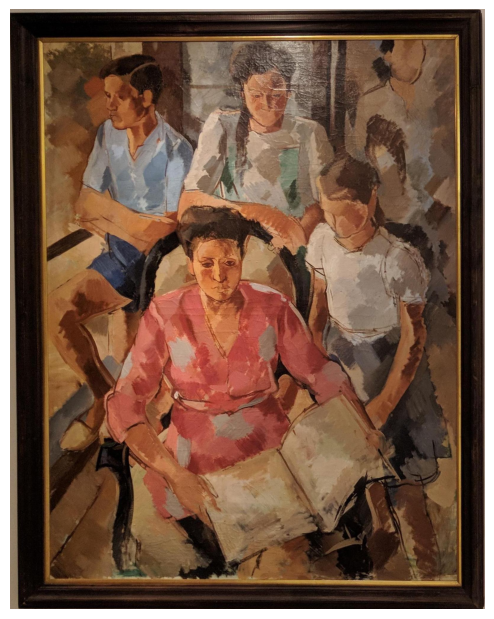

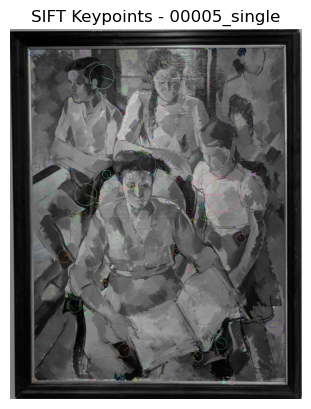

Processing queries: 100%|██████████| 30/30 [00:03<00:00,  9.23it/s]


In [77]:
# 3) Query descriptors
print("🧠 Computing SIFT for queries...")
desc_query_sift = compute_query_descriptors(
    q_imgs,
    q_names,
    preprocess_image=preprocess_image,
    segment_multiple_paintings=segment_multiple_paintings,
    validate_split_fn=lambda is_split, imgs: validate_split(is_split, imgs, min_size_ratio=MIN_SIZE_RATIO),
    background_remover=background_remover,
    nfeatures=NFEATURES,
    rootsift=ROOTSIFT,
    crop_min_ratio_single=CROP_MIN_RATIO,
    bg_crop_min_ratio=BG_CROP_MIN_RATIO,
    show_img=True,
    info=INFO_PRINT,
    save=False,
    number='05'
)

🧠 Computing ORB for queries...


Processing queries:   0%|          | 0/30 [00:00<?, ?it/s]

Cropped single image size: 1599x2024 (% of original: 95.24x98.20)
Displaying: Cropped single image 00005.jpg


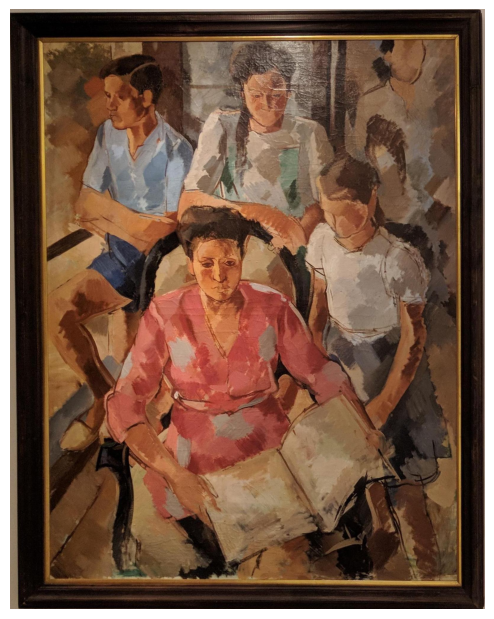

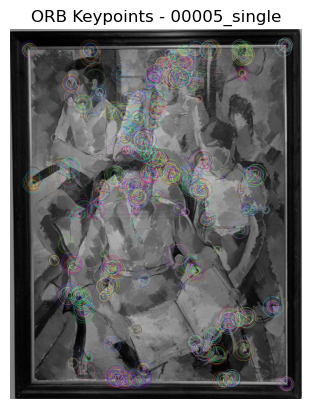

Processing queries: 100%|██████████| 30/30 [00:02<00:00, 11.26it/s]


In [63]:
DESCRIPTOR         = "ORB"       # <- switch between "SIFT" and "ORB"
NFEATURES          = 2000        # both SIFT & ORB accept this parameter- For SIFT, typical is 1200; for ORB, typical is 2000
ROOTSIFT           = False       # ignored for ORB
ORB_FAST_THRESHOLD = 20
ORB_SCORE_TYPE     = "HARRIS"    # or "FAST"
SAVE_QUERY_DESC    = True        # whether to save/load query descriptors to/from pickle (keep true if no changes in the descriptor parameters)

LOWE_RATIO         = 0.76
RATE_THRESHOLD     = 0.055 #####
MIN_SIZE_RATIO     = 0.
CROP_MIN_RATIO     = 0.20
BG_CROP_MIN_RATIO  = 0.10
SHOW_VIS           = False
INFO_PRINT         = False

# Cache file name reflects descriptor
DESC_DB_PATH   = f"results/descriptors_db_{DESCRIPTOR.lower()}.pkl"

os.makedirs("results", exist_ok=True)

# 1) Build matcher
matcher = create_matcher(DESCRIPTOR)


# 4) Query descriptors
print(f"🧠 Computing {DESCRIPTOR} for queries...")
desc_query_orb = compute_query_descriptors(
    q_imgs,
    q_names,
    preprocess_image=preprocess_image,
    segment_multiple_paintings=segment_multiple_paintings,
    validate_split_fn=lambda is_split, imgs: validate_split(is_split, imgs, min_size_ratio=MIN_SIZE_RATIO),
    background_remover=background_remover,
    descriptor_type=DESCRIPTOR,
    nfeatures=NFEATURES,
    rootsift=ROOTSIFT,
    orb_fast_threshold=ORB_FAST_THRESHOLD,
    orb_score_type=ORB_SCORE_TYPE,
    crop_min_ratio_single=CROP_MIN_RATIO,
    bg_crop_min_ratio=BG_CROP_MIN_RATIO,
    show_img=True,
    number='05'
)

In [78]:
def compute_matches(desc_query, db_descs, gt_corresps, matcher, ratio=0.76, rate_threshold=0.125, descriptor_type=None):
    """
    desc_query:  list where each element is [desc_single] or [desc_left, desc_right]
    db_descs:    list of descriptor arrays, one per DB image
    gt_corresps: list; each entry is an int, list of ints, or [-1]
    """
    predicted = []
    min_score_rate_correct = float('inf')
    max_score_rate_incorrect = float('-inf')

    # # if the descriptor_type is provided, check if the pickle file of the predicted results exists
    # if descriptor_type:
    #     pickle_path = f"results/predicted_results_{descriptor_type}_rate{rate_threshold:.3f}.pkl"
    #     if os.path.exists(pickle_path):
    #         print(f"✅ Loading predicted results from {pickle_path}")
    #         with open(pickle_path, "rb") as f:
    #             predicted = pickle.load(f)
    #         return predicted

    for qi, desc_crops in tqdm(enumerate(desc_query), total=len(desc_query), desc="Processing queries"):
        q_gt = gt_corresps[qi]
        if len(q_gt) == 2 and len(desc_crops) == 2:
            list_ranked_indices = []
            for desc_crop in desc_crops:
                ranked = rank_db_for_query_multi([desc_crop], db_descs, matcher, ratio=ratio)
                ranked_indices, ranked_scores = zip(*ranked)
                rate = ranked_scores[0] / desc_crop.shape[0] if desc_crop is not None and desc_crop.shape[0] > 0 else 0

                if ranked_indices[0] in q_gt:
                    min_score_rate_correct = min(min_score_rate_correct, rate)
                else:
                    max_score_rate_incorrect = max(max_score_rate_incorrect, rate)
                
                if rate < rate_threshold:
                    ranked_indices = [-1]
                list_ranked_indices.append(ranked_indices)

                # print the rate, gt and predicted for each crop
                # print(f"Query {qi} GT: {q_gt}, Predicted: {ranked_indices[0]}, Rate: {rate:.4f}")

        else:
            ranked = rank_db_for_query_multi(desc_crops, db_descs, matcher, ratio=ratio)
            list_ranked_indices, list_ranked_scores = zip(*ranked)
            base = desc_crops[0] if (len(desc_crops) > 0 and desc_crops[0] is not None) else None
            rate_top1 = (list_ranked_scores[0] / base.shape[0]) if (base is not None and base.shape[0] > 0) else 0
            #add the rates into the ranked tuple
            for i in range(len(ranked)):
                ranked[i] = (ranked[i][0], ranked[i][1], list_ranked_scores[i] / (db_descs[ranked[i][0]].shape[0] if db_descs[ranked[i][0]] is not None and db_descs[ranked[i][0]].shape[0] > 0 else 1200))
            # reorder the ranked based on the rate
            ranked = sorted(ranked, key=lambda x: x[2])
            
            if list_ranked_indices[0] in q_gt:
                min_score_rate_correct = min(min_score_rate_correct, rate_top1)
            else:
                max_score_rate_incorrect = max(max_score_rate_incorrect, rate_top1)
            
            if rate_top1 < rate_threshold:
                list_ranked_indices = [-1]

            # print the rate, gt and predicted for the query
            # print(f"Query {qi} GT: {q_gt}, Predicted: {list_ranked_indices[0]}, Rate: {rate:.4f}")

        # predicted.append(list_ranked_indices)
        predicted.append(ranked)

    print(f"Min score for correct matches: {min_score_rate_correct}")
    print(f"Max score for incorrect matches: {max_score_rate_incorrect}")

    # save the predicted results to a file
    # if descriptor_type:
    #     with open(f"results/predicted_results_{descriptor_type}_rate{rate_threshold:.3f}.pkl", "wb") as f:
    #         pickle.dump(predicted, f)
    return predicted


In [80]:
# 4) Ranking + mAP
print("🏆 Evaluating retrieval performance...")
pred_sift = compute_matches(
    desc_query_sift,
    db_descs,
    gt_corresps,
    matcher=matcher,
    ratio=LOWE_RATIO,
    rate_threshold=RATE_THRESHOLD,
    descriptor_type=DESCRIPTOR,
)
map5_sift = mapk(gt_corresps, pred_sift, k=5, skip_unknown=False)
map1_sift = mapk(gt_corresps, pred_sift, k=1, skip_unknown=False)

print(f"✅ mAP@1 = {map1_sift:.4f}")
print(f"✅ mAP@5 = {map5_sift:.4f}")

🏆 Evaluating retrieval performance...


Processing queries: 100%|██████████| 1/1 [00:09<00:00,  9.01s/it]

Min score for correct matches: inf
Max score for incorrect matches: 0.28
✅ mAP@1 = 0.0000
✅ mAP@5 = 0.0000


In [85]:
DB_FOLDER      = "../Data/BBDD/"
QUERY_FOLDER   = "../Data/Week4/qsd1_w4/"
GT_PATH        = "../Data/Week4/qsd1_w4/gt_corresps.pkl"

DESCRIPTOR         = "CSIFT"     # <- "SIFT" | "ORB" | "CSIFT"
COLOR_SPACE        = "OPPONENT"  # <- for CSIFT: "OPPONENT" | "RGB" | "HSV"

NFEATURES          = 1500        # works for SIFT/CSIFT; ORB uses same param name
ROOTSIFT           = True        # applies to SIFT/CSIFT only
ORB_FAST_THRESHOLD = 20
ORB_SCORE_TYPE     = "HARRIS"    # or "FAST"
SAVE_QUERY_DESC    = True        # whether to save/load query descriptors to/from pickle (keep true if no changes in the descriptor parameters)

LOWE_RATIO         = 0.76
RATE_THRESHOLD     = 0.05 #####
MIN_SIZE_RATIO     = 0.20
CROP_MIN_RATIO     = 0.20
BG_CROP_MIN_RATIO  = 0.10
SHOW_VIS           = False
INFO_PRINT         = False

DESC_DB_PATH   = f"results/descriptors_db_{DESCRIPTOR.lower()}_{COLOR_SPACE.lower() if DESCRIPTOR.upper()=='CSIFT' else ''}.pkl".replace("__","_")

os.makedirs("results", exist_ok=True)

# 1) Matcher
matcher = create_matcher(DESCRIPTOR)

# 2) DB descriptors
db_descs, db_names = build_or_load_db_descriptors(
    DB_FOLDER,
    DESC_DB_PATH,
    descriptor_type=DESCRIPTOR,
    nfeatures=NFEATURES,
    rootsift=ROOTSIFT,
    color_space=COLOR_SPACE,
    orb_fast_threshold=ORB_FAST_THRESHOLD,
    orb_score_type=ORB_SCORE_TYPE,
    use_cache=True,
    progress=True,
)

# 3) Queries + GT
print("📥 Loading query images...")
q_names, q_imgs = load_images_from_folder(QUERY_FOLDER)
print("📥 Loading ground-truth correspondences...")
with open(GT_PATH, "rb") as f:
    gt_corresps = pickle.load(f)
print(f"→ {len(gt_corresps)} GT entries loaded")
# 4) Query descriptors
print(f"🧠 Computing {DESCRIPTOR} for queries...")
desc_query_csift = compute_query_descriptors(
    q_imgs,
    q_names,
    preprocess_image=preprocess_image,
    segment_multiple_paintings=segment_multiple_paintings,
    validate_split_fn=lambda is_split, imgs: validate_split(is_split, imgs, min_size_ratio=MIN_SIZE_RATIO),
    background_remover=background_remover,
    descriptor_type=DESCRIPTOR,
    nfeatures=NFEATURES,
    rootsift=ROOTSIFT,
    color_space=COLOR_SPACE,
    orb_fast_threshold=ORB_FAST_THRESHOLD,
    orb_score_type=ORB_SCORE_TYPE,
    crop_min_ratio_single=CROP_MIN_RATIO,
    bg_crop_min_ratio=BG_CROP_MIN_RATIO,
    show_img=SHOW_VIS,
    info=INFO_PRINT,
    save=False,
    number='05'
)

✅ Loading DB descriptors from results/descriptors_db_csift_opponent.pkl
📥 Loading query images...
📥 Loading ground-truth correspondences...
→ 30 GT entries loaded
🧠 Computing CSIFT for queries...


Processing queries:   0%|          | 0/30 [00:00<?, ?it/s]

Cropped single image size: 1599x2024 (% of original: 95.24x98.20)


Processing queries: 100%|██████████| 30/30 [00:03<00:00,  7.78it/s]


In [86]:
# 5) Ranking + mAP
print("🔍 Computing matches...")
pred_csift = compute_matches(
    desc_query_csift,
    db_descs,
    gt_corresps,
    matcher=matcher,
    ratio=LOWE_RATIO,
    rate_threshold=RATE_THRESHOLD,
    descriptor_type=DESCRIPTOR,
)
map5_csift = mapk(gt_corresps, pred_csift, k=5, skip_unknown=False)
map1_csift = mapk(gt_corresps, pred_csift, k=1, skip_unknown=False)

print(f"✅ mAP@1 = {map1_csift:.4f}")
print(f"✅ mAP@5 = {map5_csift:.4f}")

🔍 Computing matches...


Processing queries: 100%|██████████| 1/1 [00:20<00:00, 20.92s/it]

Min score for correct matches: inf
Max score for incorrect matches: 0.14733333333333334
✅ mAP@1 = 0.0000
✅ mAP@5 = 0.0000


In [90]:
pred_sift

[[(1, 0, 0.0),
  (54, 1, 0.0008326394671107411),
  (166, 1, 0.0008326394671107411),
  (21, 1, 0.0008333333333333334),
  (25, 1, 0.0008333333333333334),
  (26, 1, 0.0008333333333333334),
  (96, 1, 0.0008333333333333334),
  (176, 1, 0.0008333333333333334),
  (4, 2, 0.0016666666666666668),
  (121, 2, 0.0016666666666666668),
  (83, 2, 0.002472187886279357),
  (78, 3, 0.0025),
  (151, 3, 0.0025),
  (191, 3, 0.0025),
  (273, 3, 0.0025),
  (184, 2, 0.0025806451612903226),
  (39, 4, 0.0033305578684429643),
  (5, 4, 0.0033333333333333335),
  (44, 4, 0.0033333333333333335),
  (46, 4, 0.0033333333333333335),
  (63, 4, 0.0033333333333333335),
  (93, 4, 0.0033333333333333335),
  (132, 4, 0.0033333333333333335),
  (155, 4, 0.0033333333333333335),
  (174, 4, 0.0033333333333333335),
  (198, 4, 0.0033333333333333335),
  (215, 4, 0.0033333333333333335),
  (230, 4, 0.0033333333333333335),
  (252, 4, 0.0033333333333333335),
  (264, 4, 0.0033333333333333335),
  (18, 5, 0.004166666666666667),
  (42, 5, 0.00

In [87]:
pred_csift

[[(1, 0, 0.0),
  (11, 0, 0.0),
  (12, 0, 0.0),
  (14, 0, 0.0),
  (21, 0, 0.0),
  (32, 0, 0.0),
  (34, 0, 0.0),
  (36, 0, 0.0),
  (40, 0, 0.0),
  (43, 0, 0.0),
  (45, 0, 0.0),
  (53, 0, 0.0),
  (54, 0, 0.0),
  (55, 0, 0.0),
  (65, 0, 0.0),
  (69, 0, 0.0),
  (71, 0, 0.0),
  (74, 0, 0.0),
  (75, 0, 0.0),
  (77, 0, 0.0),
  (83, 0, 0.0),
  (93, 0, 0.0),
  (96, 0, 0.0),
  (102, 0, 0.0),
  (103, 0, 0.0),
  (110, 0, 0.0),
  (114, 0, 0.0),
  (118, 0, 0.0),
  (119, 0, 0.0),
  (125, 0, 0.0),
  (138, 0, 0.0),
  (140, 0, 0.0),
  (143, 0, 0.0),
  (147, 0, 0.0),
  (148, 0, 0.0),
  (151, 0, 0.0),
  (163, 0, 0.0),
  (166, 0, 0.0),
  (168, 0, 0.0),
  (177, 0, 0.0),
  (195, 0, 0.0),
  (198, 0, 0.0),
  (210, 0, 0.0),
  (224, 0, 0.0),
  (226, 0, 0.0),
  (228, 0, 0.0),
  (239, 0, 0.0),
  (241, 0, 0.0),
  (252, 0, 0.0),
  (254, 0, 0.0),
  (273, 0, 0.0),
  (274, 0, 0.0),
  (283, 0, 0.0),
  (284, 0, 0.0),
  (8, 1, 0.0006662225183211193),
  (57, 1, 0.0006662225183211193),
  (156, 1, 0.0006662225183211193),
  (3

In [88]:
DB_FOLDER      = "../Data/BBDD/"
QUERY_FOLDER   = "../Data/Week4/qsd1_w4/"
GT_PATH        = "../Data/Week4/qsd1_w4/gt_corresps.pkl"

DESCRIPTOR         = "ORB"       # <- switch between "SIFT" and "ORB"
NFEATURES          = 2000        # both SIFT & ORB accept this parameter- For SIFT, typical is 1200; for ORB, typical is 2000
ROOTSIFT           = False       # ignored for ORB
ORB_FAST_THRESHOLD = 20
ORB_SCORE_TYPE     = "HARRIS"    # or "FAST"
SAVE_QUERY_DESC    = True        # whether to save/load query descriptors to/from pickle (keep true if no changes in the descriptor parameters)

LOWE_RATIO         = 0.76
RATE_THRESHOLD     = 0.055 #####
MIN_SIZE_RATIO     = 0.
CROP_MIN_RATIO     = 0.20
BG_CROP_MIN_RATIO  = 0.10
SHOW_VIS           = False
INFO_PRINT         = False

# Cache file name reflects descriptor
DESC_DB_PATH   = f"results/descriptors_db_{DESCRIPTOR.lower()}.pkl"

os.makedirs("results", exist_ok=True)

# 1) Build matcher
matcher = create_matcher(DESCRIPTOR)

# 2) DB descriptors
db_descs, db_names = build_or_load_db_descriptors(
    DB_FOLDER,
    DESC_DB_PATH,
    descriptor_type=DESCRIPTOR,
    nfeatures=NFEATURES,
    rootsift=ROOTSIFT,
    orb_fast_threshold=ORB_FAST_THRESHOLD,
    orb_score_type=ORB_SCORE_TYPE,
    use_cache=True,
    progress=True,
)

# 3) Queries + GT
print("📥 Loading query images...")
q_names, q_imgs = load_images_from_folder(QUERY_FOLDER)
print("📥 Loading ground-truth correspondences...")
with open(GT_PATH, "rb") as f:
    gt_corresps = pickle.load(f)
print(f"→ {len(gt_corresps)} GT entries loaded")

# 4) Query descriptors
print(f"🧠 Computing {DESCRIPTOR} for queries...")
desc_query_orb = compute_query_descriptors(
    q_imgs,
    q_names,
    preprocess_image=preprocess_image,
    segment_multiple_paintings=segment_multiple_paintings,
    validate_split_fn=lambda is_split, imgs: validate_split(is_split, imgs, min_size_ratio=MIN_SIZE_RATIO),
    background_remover=background_remover,
    descriptor_type=DESCRIPTOR,
    nfeatures=NFEATURES,
    rootsift=ROOTSIFT,
    orb_fast_threshold=ORB_FAST_THRESHOLD,
    orb_score_type=ORB_SCORE_TYPE,
    crop_min_ratio_single=CROP_MIN_RATIO,
    bg_crop_min_ratio=BG_CROP_MIN_RATIO,
    show_img=SHOW_VIS,
    info=INFO_PRINT,
    save=False,
    number='05'
)

# 5) Ranking + mAP
pred_orb = compute_matches(
    desc_query_orb,
    db_descs,
    gt_corresps,
    matcher=matcher,
    ratio=LOWE_RATIO,
    rate_threshold=RATE_THRESHOLD,
    descriptor_type=DESCRIPTOR,
)

map5_orb = mapk(gt_corresps, pred_orb, k=5, skip_unknown=False)
map1_orb = mapk(gt_corresps, pred_orb, k=1, skip_unknown=False)

print(f"✅ mAP@1 = {map1_orb:.4f}")
print(f"✅ mAP@5 = {map5_orb:.4f}")


✅ Loading DB descriptors from results/descriptors_db_orb.pkl
📥 Loading query images...
📥 Loading ground-truth correspondences...
→ 30 GT entries loaded
🧠 Computing ORB for queries...


Processing queries: 100%|██████████| 30/30 [00:02<00:00, 12.83it/s]


Cropped single image size: 1599x2024 (% of original: 95.24x98.20)


Processing queries: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]

Min score for correct matches: inf
Max score for incorrect matches: 0.217
✅ mAP@1 = 0.0000
✅ mAP@5 = 0.0000


In [89]:
pred_orb

[[(1, 0, 0.0),
  (252, 2, 0.001),
  (65, 4, 0.002),
  (42, 5, 0.0025),
  (95, 5, 0.0025),
  (152, 5, 0.0025),
  (283, 5, 0.002649708532061473),
  (165, 5, 0.0027578599007170436),
  (16, 6, 0.003),
  (64, 6, 0.003),
  (93, 6, 0.003),
  (112, 6, 0.003),
  (122, 6, 0.003),
  (138, 6, 0.003),
  (240, 6, 0.0034602076124567475),
  (76, 7, 0.0035),
  (108, 7, 0.0035),
  (118, 7, 0.0035),
  (143, 7, 0.0035),
  (144, 7, 0.0035),
  (156, 7, 0.0035),
  (230, 7, 0.0035),
  (253, 7, 0.0035),
  (279, 7, 0.0035),
  (280, 7, 0.0035),
  (38, 7, 0.003757380568974772),
  (231, 7, 0.003816793893129771),
  (19, 8, 0.004),
  (28, 8, 0.004),
  (43, 8, 0.004),
  (50, 8, 0.004),
  (71, 8, 0.004),
  (127, 8, 0.004),
  (224, 8, 0.004),
  (115, 8, 0.004149377593360996),
  (282, 8, 0.0041753653444676405),
  (250, 6, 0.004282655246252677),
  (186, 8, 0.004427227448810182),
  (55, 9, 0.0045),
  (62, 9, 0.0045),
  (66, 9, 0.0045),
  (73, 9, 0.0045),
  (85, 9, 0.0045),
  (88, 9, 0.0045),
  (111, 9, 0.0045),
  (121, 9,

Displaying: SIFT Keypoints Visualization


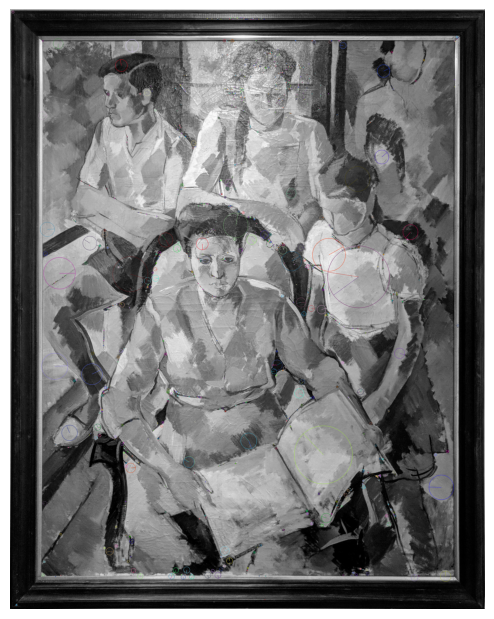

Displaying: Matched Keypoints between Query and DB Image


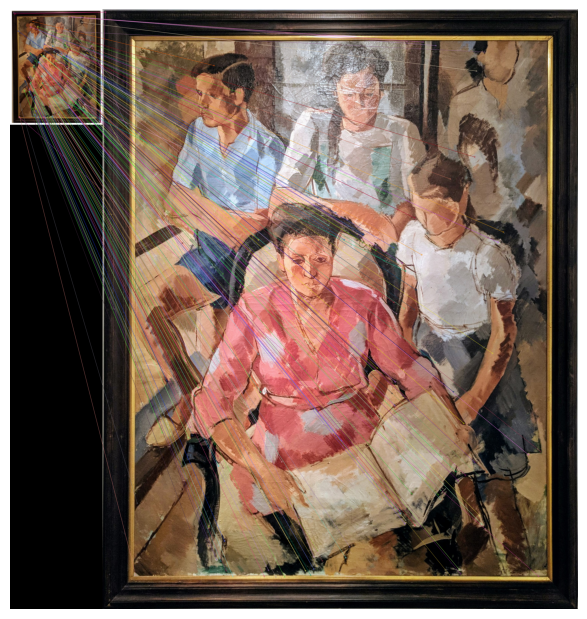

In [54]:
DB_FOLDER      = "../Data/BBDD/"
img_bgr = cv2.imread(DB_FOLDER + "bbdd_00081.jpg")
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create(nfeatures=NFEATURES)
kp, des = sift.detectAndCompute(gray, None)
vis = cv2.drawKeypoints(gray, kp, img_bgr.copy(), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plot_image(vis, title="SIFT Keypoints Visualization")

#draw matches between query and db image
# for that, we need a query image
query_img = cv2.imread("results/sample_presentation2.png")
query_gray = cv2.cvtColor(query_img, cv2.COLOR_BGR2GRAY)
query_kp, query_des = sift.detectAndCompute(query_gray, None)

# display matches
matches = matcher.knnMatch(query_des, des, k=2)
good_matches = []
for m, n in matches:
    if m.distance < 0.76 * n.distance:
        good_matches.append(m)
        
matched_img = cv2.drawMatches(query_img, query_kp, img_bgr, kp, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plot_image(matched_img, title="Matched Keypoints between Query and DB Image")


Displaying: ORB Keypoints Visualization


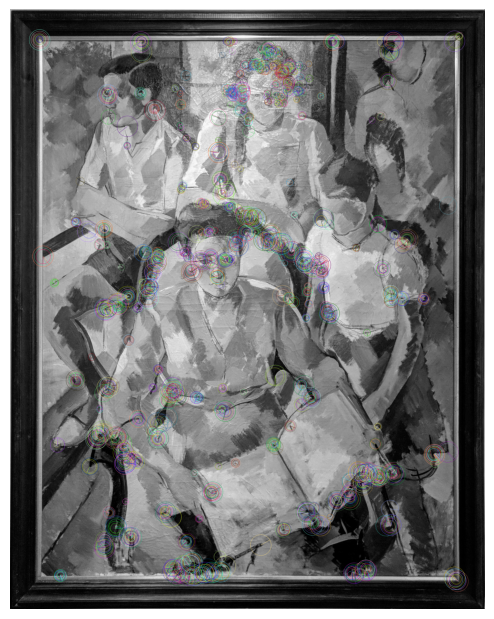

Displaying: ORB Matches (good=16)


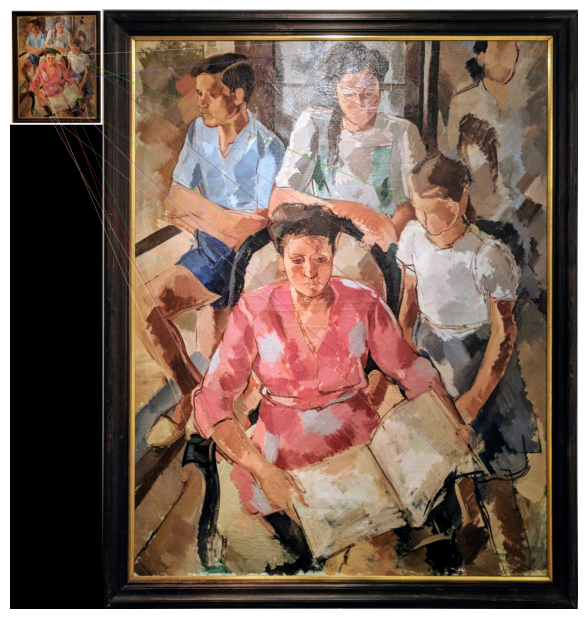

In [66]:
# --- ORB keypoints on a DB image (same style as your SIFT snippet) ---
DB_FOLDER = "../Data/BBDD/"
img_bgr = cv2.imread(DB_FOLDER + "bbdd_00081.jpg")
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

# ORB with your params
score = cv2.ORB_HARRIS_SCORE if ORB_SCORE_TYPE.upper() == "HARRIS" else cv2.ORB_FAST_SCORE
orb = cv2.ORB_create(
    nfeatures=NFEATURES,
    scaleFactor=1.2,
    nlevels=8,
    edgeThreshold=31,
    firstLevel=0,
    WTA_K=2,                     # keep 2 → NORM_HAMMING works; if you change to 4 use NORM_HAMMING2
    scoreType=score,
    patchSize=31,
    fastThreshold=ORB_FAST_THRESHOLD
)
kp, des = orb.detectAndCompute(gray, None)

vis = cv2.drawKeypoints(
    gray, kp, img_bgr.copy(),
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
plot_image(vis, title="ORB Keypoints Visualization")

# --- ORB matches between a query image and the same DB image ---
query_img = cv2.imread("results/sample_presentation2.png")
query_gray = cv2.cvtColor(query_img, cv2.COLOR_BGR2GRAY)
query_kp, query_des = orb.detectAndCompute(query_gray, None)

if query_des is None or des is None or len(query_des) == 0 or len(des) == 0:
    print("⚠️ No ORB descriptors to match.")
else:
    # make sure matcher is Hamming for ORB (your create_matcher should already do this)
    # e.g., matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    matches = matcher.knnMatch(query_des, des, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < LOWE_RATIO * n.distance:   # your LOWE_RATIO=0.76
            good_matches.append(m)

    matched_img = cv2.drawMatches(
        query_img, query_kp, img_bgr, kp,
        good_matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    plot_image(matched_img, title=f"ORB Matches (good={len(good_matches)})")


Displaying: Matched Keypoints between Query and DB Image


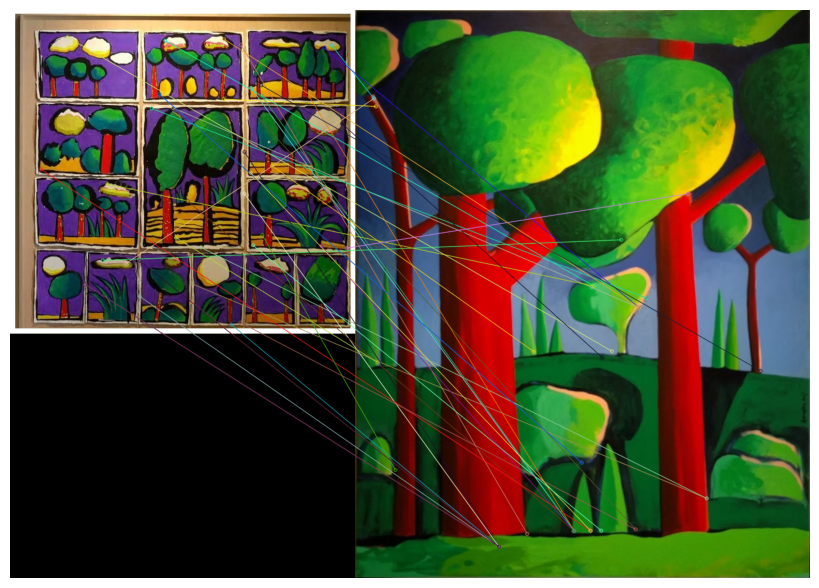

In [65]:
plot_image(matched_img, title="Matched Keypoints between Query and DB Image")

Displaying: Matched Keypoints between Query and DB Image


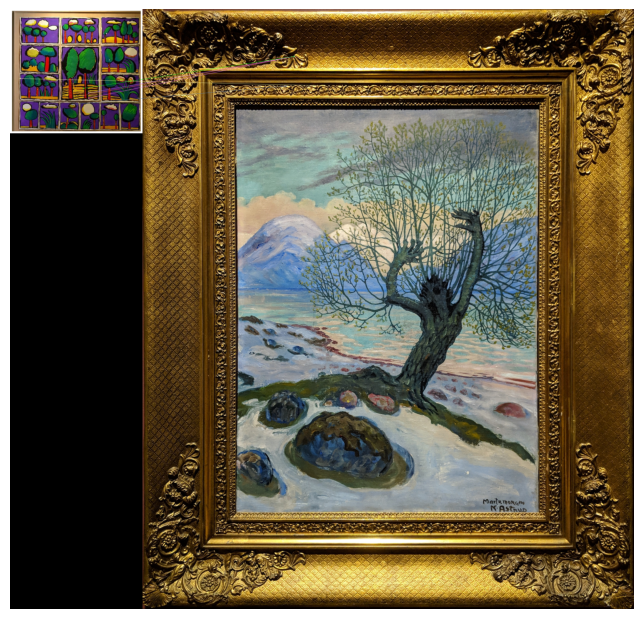

In [ ]:
plot_image(matched_img, title="Matched Keypoints between Query and DB Image")

Displaying: Matched Keypoints between Query and DB Image


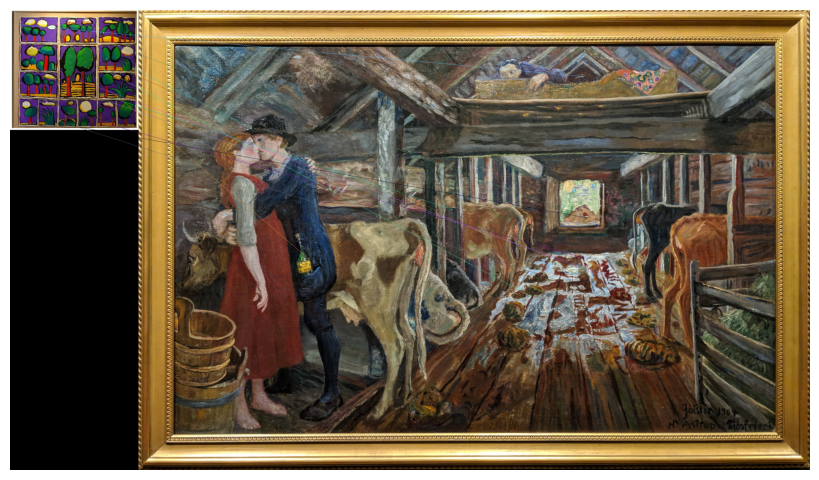

In [55]:
plot_image(matched_img, title="Matched Keypoints between Query and DB Image")

Displaying: Matched Keypoints between Query and DB Image


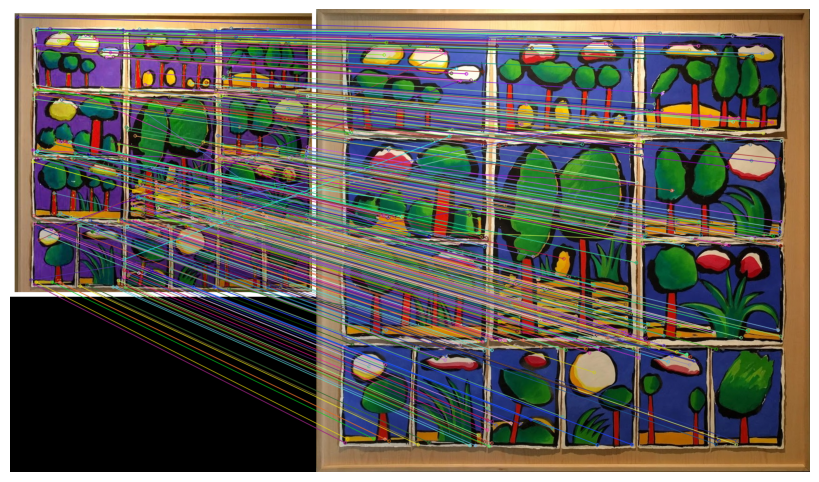

In [50]:
plot_image(matched_img, title="Matched Keypoints between Query and DB Image")